# Dermatologist-AI

### About the project
In this mini project, I will design an algorithm that can visually diagnose melanoma, the deadliest form of skin cancer. In particular, algorithm will distinguish this malignant skin tumor from two types of benign lesions (nevi and seborrheic keratoses).

The data and objective are pulled from the 2017 ISIC Challenge on Skin Lesion Analysis Towards Melanoma Detection. As part of the challenge, I was tasked to design an algorithm to diagnose skin lesion images as one of three different skin diseases (melanoma, nevus, or seborrheic keratosis). In this project, I will create a model to generate your own predictions.

## Importing the libraries and dataset

In [0]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import os
from shutil import copyfile
import zipfile

In [1]:
from google.colab import drive, files
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def unzip_file(name, target):
    zip_ref = zipfile.ZipFile(base_url + name, 'r')
    zip_ref.extractall(target)
    zip_ref.close()

In [45]:
base_url = 'drive/My Drive/HAM10000/'
unzip_file("HAM10000_images_part_1.zip", target = base_url + "images")
unzip_file("HAM10000_images_part_2.zip", target = base_url + "images")
os.listdir(base_url)

['hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1.zip',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'HAM10000_images_part_2.zip',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv',
 'images']

In [0]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [47]:
# total_images = len(os.listdir(base_url + 'images'))
df = pd.read_csv(base_url + 'HAM10000_metadata.csv')
df.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

## Exploratory Data Analysis - EDA

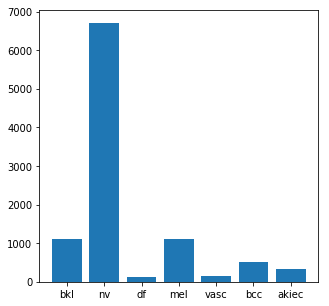

In [48]:
lesion_types = df.dx.unique()
lesion_count = [df.dx.to_list().count(i) for i in lesion_types]
plt.rcParams["figure.figsize"] = [5,5]
plt.bar(lesion_types, lesion_count)
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


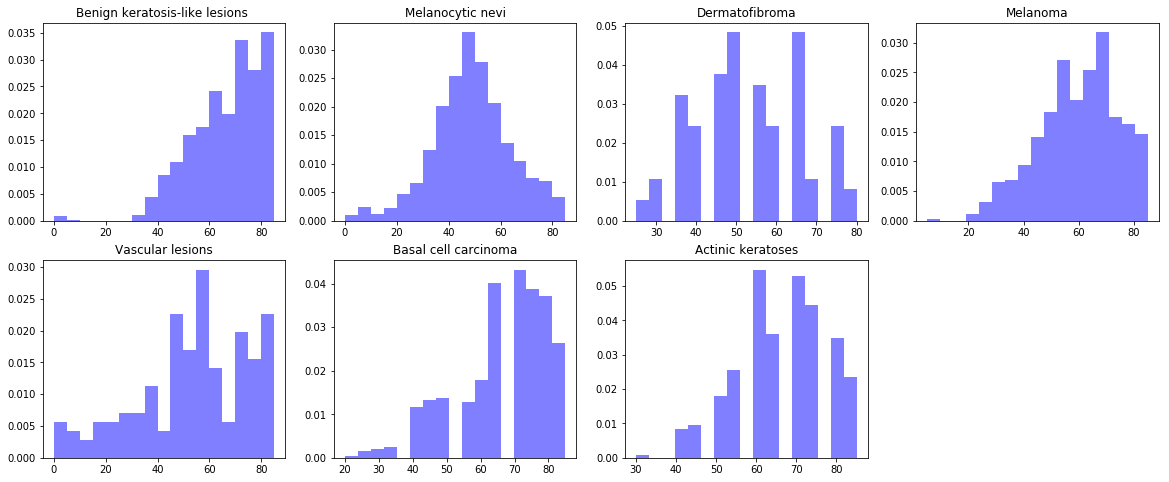

In [49]:
plt.rcParams["figure.figsize"] = [20,8]

for i in range(len(lesion_types)):
    df_lesion = df[df.dx == lesion_types[i]]
    age_distribution = df_lesion.age.to_list()
    plt.subplot(2, 4, i + 1)
    plt.title(lesion_type_dict[lesion_types[i]])
    plt.hist(age_distribution, bins=17, normed=1, facecolor='blue', alpha=0.5)
    
plt.show()

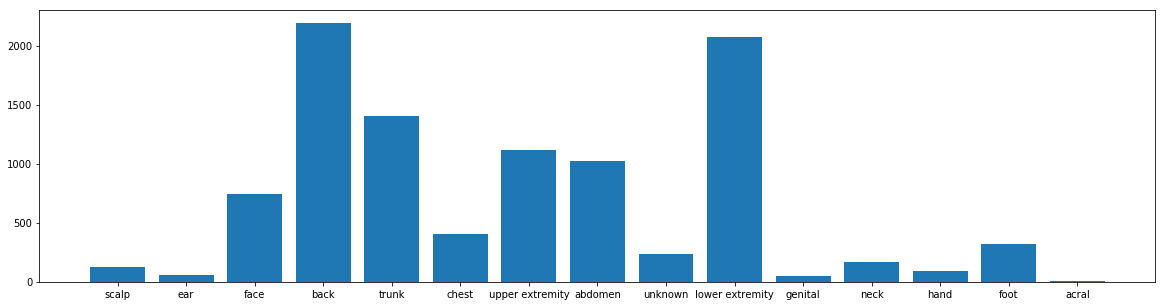

In [50]:
localization_types = df.localization.unique()
localization_count = [df.localization.to_list().count(i) for i in localization_types]
plt.rcParams["figure.figsize"] = [20,5]
plt.bar(localization_types, localization_count)
plt.show()

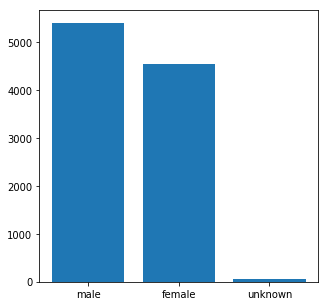

In [51]:
gender_types = df.sex.unique()
gender_count = [df.sex.to_list().count(i) for i in gender_types]
plt.rcParams["figure.figsize"] = [5,5]
plt.bar(gender_types, gender_count)
plt.show()

In [0]:
df = df.drop(df[df.dx == 'nv'].iloc[:5000].index)

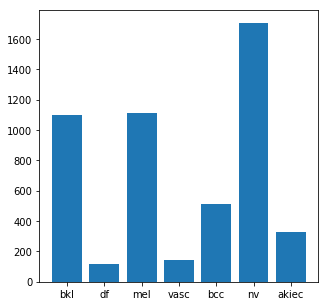

In [53]:
lesion_types = df.dx.unique()
lesion_count = [df.dx.to_list().count(i) for i in lesion_types]
plt.rcParams["figure.figsize"] = [5,5]
plt.bar(lesion_types, lesion_count)
plt.show()

## Create train test split

In [0]:
from sklearn.model_selection import train_test_split
image_id = df.image_id.to_list()
lesion_type = df.dx.to_list()
image_id_train, image_id_test, lesion_train, lesion_test = train_test_split(image_id, lesion_type, test_size=0.2, random_state=42)

In [55]:
def sort_images(dataset_type, image_id, lesion_type):
    try:
        os.mkdir(base_url + dataset_type)
        print('Folder created')
    except:
        None
    for i, j in zip(image_id, lesion_type):
        folders_created = os.listdir(base_url + dataset_type)
        if j not in folders_created:
            os.mkdir(base_url + dataset_type + '/' + j)
        destination = base_url + dataset_type + '/' + j + '/' + i + '.jpg'
        source = base_url + 'images/' + i + '.jpg'
        # Transfering the images from source to destination
        try:
            copyfile(source, destination)
        except:
            None

sort_images('train', image_id_train, lesion_train)
sort_images('test', image_id_test, lesion_test)

Folder created
Folder created


## Creating CNN model for training

### Transfer Learning

In [0]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [57]:
base_url = 'drive/My Drive/HAM10000/'

batch_size = 32

train_batches = ImageDataGenerator(
    preprocessing_function = keras.applications.mobilenet.preprocess_input).flow_from_directory(
    base_url + "train",
    target_size=(224, 224),
    batch_size=batch_size)
test_batches = ImageDataGenerator(
    preprocessing_function = keras.applications.mobilenet.preprocess_input).flow_from_directory(
    base_url + "test",
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=False)

train_batches_size = len(train_batches.classes)/batch_size
test_batches_size = len(test_batches.classes)/batch_size

Found 4012 images belonging to 7 classes.
Found 1003 images belonging to 7 classes.


In [58]:
mobile = keras.applications.mobilenet.MobileNet()
x = mobile.layers[-6].output
x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=mobile.input, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
# Freeze the weights of the layers that we aren't training (training the last 23)
for layer in model.layers[:-23]:
    layer.trainable = False

In [0]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
# Add weights to make the model more sensitive to melanoma
class_weights={
    0: 1.0,  # akiec
    1: 1.0,  # bcc
    2: 1.0,  # bkl
    3: 1.0,  # df
    4: 3.0,  # mel
    5: 1.0,  # nv
    6: 1.0,  # vasc
}

In [61]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
callbacks_list = [checkpoint]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_batches_size,
                              class_weight=class_weights,
                              validation_data=test_batches,
                              validation_steps=test_batches_size,
                              epochs=30,
                              verbose=1,
                              callbacks=callbacks_list)

Epoch 1/30
126/125 [==============================] - 59s 466ms/step - loss: 2.6416 - acc: 0.4224 - val_loss: 4.6919 - val_acc: 0.2413

Epoch 00001: val_acc improved from -inf to 0.24128, saving model to model.h5
Epoch 2/30
126/125 [==============================] - 51s 404ms/step - loss: 1.4399 - acc: 0.5642 - val_loss: 2.8663 - val_acc: 0.3998

Epoch 00002: val_acc improved from 0.24128 to 0.39980, saving model to model.h5
Epoch 3/30
126/125 [==============================] - 52s 409ms/step - loss: 1.1419 - acc: 0.6464 - val_loss: 2.6614 - val_acc: 0.4317

Epoch 00003: val_acc improved from 0.39980 to 0.43170, saving model to model.h5
Epoch 4/30
126/125 [==============================] - 52s 415ms/step - loss: 0.9175 - acc: 0.7320 - val_loss: 5.3198 - val_acc: 0.3370

Epoch 00004: val_acc did not improve from 0.43170
Epoch 5/30
126/125 [==============================] - 54s 426ms/step - loss: 0.7670 - acc: 0.7775 - val_loss: 6.2090 - val_acc: 0.2861

Epoch 00005: val_acc did not impr

In [0]:
y_true = test_batches.classes
predictions = model.predict_generator(test_batches, steps=test_batch_size, verbose=1)
print(len(predictions), len(y_true))

In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

predictions = predictions[:2755]
y_true = y_true[:2755]
cm = confusion_matrix(y_true, predictions)
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
plot_confusion_matrix(cm, cm_plot_labels)

## Prediction and Evaluation

In [0]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
test_image = image.load_img('dataset/train/melanoma/ISIC_0015045.jpg', target_size = (348, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
model = load_model('model_without_transfer_learning.h5')
result = classifier.predict(test_image)
print(result)